# 교차 검증과 그리드 서치

### 검증 세트
테스트 세트를 사용하지 않고 모델이 과대적합인지 과소적합인지 판단하기 위해 사용한다.

테스트 세트로 사용하게 되면 모델이 테스트 세트까지 학습하여 새로운 데이터가 들어왔을 때 좋지 않은 성능을 나타낼 수 있다.

검증세트는 이를 방지하기 위해 훈련 세트에서 일부분을 검증 데이터로 만들어 모델을 평가하기 위해 사용된다.

보통 20~30%를 테스트 세트와 검증 세트로 떼어 놓는다. 하지만 훈련 데이터가 아주 많다면 단 몇 %만 떼어 놓아도 전체 데이터를 대표하는데 문제가 없다.

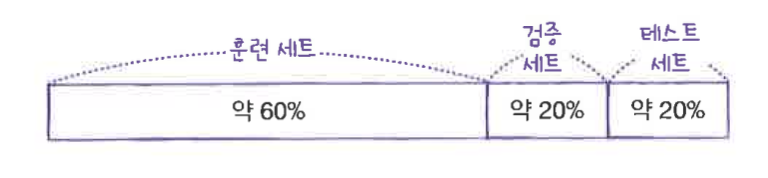

### 교차 검증
검증 세트를 만들기 위해 훈련 데이터가 줄어 좋은 성능을 나타내지 못할 수 있다. 좀 더 안정적인 검증 점수를 얻고 훈련에 더 많은 데이터를 사용하기 위해 교차 검증(cross vaildation)을 이용한다. 

교차 검증은 검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복하여 얻은 점수를 평균하여 최종 검증 점수를 얻는다.

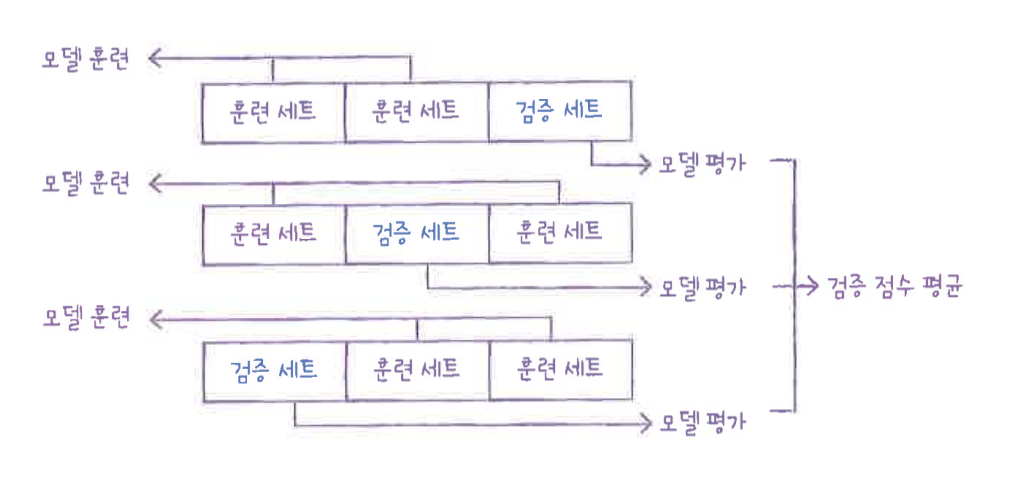




In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [3]:
wine = pd.read_csv('/Users/ujong-yun/Documents/GitHub/machinelearning-deeplearning/wine.csv')
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [5]:
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)


In [7]:
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [10]:
dt = DecisionTreeClassifier()
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.8615384615384616


In [12]:
# 교차 검증
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00607395, 0.00481987, 0.00500894, 0.00575018, 0.00481105]), 'score_time': array([0.000386  , 0.00037599, 0.00033188, 0.00034189, 0.00034189]), 'test_score': array([0.87211538, 0.85384615, 0.8719923 , 0.85563041, 0.83830606])}


In [15]:
print(np.mean(scores['test_score']))

0.8583780632264751


In [17]:
#사이킷런의 StratifiedKFold를 통해 교차 검증에서 폴드를 어떻게 나눌지 결정한다. 
#기본적으로 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용한다.
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)
print(np.mean(scores['test_score']))

0.8595401659997037


## 하이퍼마라미터 튜닝
머신러닝 모델이 학습하는 파라미터를 모델 파라미터라 한다. 반면에 사용자가 지정해야만 하는 파라미터를 하이퍼파라미터라 한다.


## 그리드 서치(GridSearch)
하이퍼파리미터 탐색과 교차 검증을 한 번에 수행한다. 

그리드 서치는 조정할 하이퍼파리미터 값들은 순차적으로 넣은 후 그 중 최적의 성능을 나타내는 하이퍼파라미터 값을 선택한다.


In [21]:
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs = -1)
# n_jobs : 병렬 실행에 사용할 CPU 코어 수를 지정하는 매개변수., 기본값 1, -1로 지정하면 시스템에 있는 모든 코어를 사용

In [22]:
gs.fit(train_input, train_target)
dt = gs.best_estimator_ #최적의 하이퍼파라미터를 적용한 모델을 best_estimator 메개변수에 저장한다.
print(dt.score(train_input, train_target))

0.9615162593804117


In [24]:
#최적의 하이퍼파라미터값 확인하기
print(gs.best_params_)
#수행한 교차 검증의 평균 점수 확인
print(gs.cv_results_['mean_test_score'])

{'min_impurity_decrease': 0.0001}
[0.86800067 0.86453617 0.86492226 0.86780891 0.86761605]


In [26]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [27]:
#복잡한 하이퍼파라미터값 확인하기
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
          'max_depth' : range(5, 20 ,1),
          'min_samples_split' : range(2, 100, 10)}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs= -1)
gs.fit(train_input, train_target)
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [28]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731
